# Volumetric data processing

Please see the `segmentation_info.py` module, which contains a list of odorants (`odors_to_select`) to potentially use as a subsetted panel for analysis (e.g. to exclude the highest concentrations)


In [1]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pickle
import sys
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite
import imageio

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

from bokeh.io import output_notebook 
output_notebook()

2024-06-24 12:18:13.997417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 12:18:13.997461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 12:18:13.998591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 12:18:14.007135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

In [17]:
sys.path.insert(0, '../')
from experiment_info import samples, data_dir, puffs, params
from segmentation_info import odors_to_select, puffs_filt
import functions as fn
import skimage as ski
from collections import defaultdict

samp_index = 3

motion_correction = True

# set parameters
K = 10  # number of neurons expected per patch
gSig = [4, 4, 1]  # expected half size of neurons
merge_thresh = 0.9  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

gSig_string = '_'.join([str(x) for x in gSig])
results_dir_base = "results/caiman/odor_subset"
results_dir = f"{results_dir_base}/gSig_{gSig_string}/K{K}"
os.makedirs(results_dir, exist_ok=True)


### Select specific odors

In [4]:
videos = {}
for samp in samples:
    vids_selected = []
    vids_all = glob.glob(f"{data_dir}/{samp}/*.registered.tif")
    vids_all = sorted(vids_all)
    assert len(vids_all) == 72, f"Expected 72 videos, got {len(vids_all)}"
    if len(odors_to_select) == 0:
        vids_selected = vids_all[:36]
    else:
        for i,v in enumerate(vids_all):
            assert puffs[i].number == i
            if puffs[i].odor_name in odors_to_select and puffs[i].trial==1:
                vids_selected.append(v)

    # take first 36 videos
    # vids_all = vids_all[:36]
    # v = v[6:8] # for testing
    videos[samp] = vids_selected
    print(f"Selected {len(vids_selected)} videos for {samp}")

Selected 21 videos for 230913_ORL_GCaMP6f_F1
Selected 21 videos for 230913_ORL_GCaMP6f_F2
Selected 21 videos for 230914_ORL_GCaMP6f_F1
Selected 21 videos for 230914_ORL_GCaMP6f_F2
Selected 21 videos for 230915_ORL_GCaMP6f_F1
Selected 21 videos for 230913_U52_GCaMP6f_F2
Selected 21 videos for 230913_U52_GCaMP6f_F3
Selected 21 videos for 230914_U52_GCaMP6f_F1
Selected 21 videos for 230914_U52_GCaMP6f_F2
Selected 21 videos for 230915_U52_GCaMP6f_F2
Selected 21 videos for 230913_FCV_GCaMP6f_F1
Selected 21 videos for 230914_FCV_GCaMP6f_F1
Selected 21 videos for 230914_FCV_GCaMP6f_F2
Selected 21 videos for 230914_FCV_GCaMP6f_F3
Selected 21 videos for 230915_FCV_GCaMP6f_F1


### Load data and apply median filter

In [6]:
loaded_normalized_videos = []
    
def apply_median_filter(v):
    filtered_frames = []
    for frame in v:
        filtered_frames.append( ski.filters.median(frame, footprint=np.ones((3, 3, 1)), behavior='ndimage') )
    return cm.movie(np.array(filtered_frames))

# to make shorter gifs, select a smaller subset of frames
# params['n_frames_to_analyze'] = 50

for i,samp in enumerate(videos):
    if i != samp_index:
        continue
    vid_list = fn.load_videos_into_list(videos[samp], params, normalize=True)
    for vid in vid_list:
        loaded_normalized_videos.append(apply_median_filter(vid))
        # loaded_normalized_videos.append(vid)

Y = cm.concatenate(loaded_normalized_videos)


### Make Gif, which is extremely useful for sanity-checking the segmentation results to see if they're sensisble.

In [19]:
movie_2d = np.max(Y, axis=3)
# movie_2d = Y[...,15]
movie_2d = (movie_2d - np.min(movie_2d))/(np.max(movie_2d) - np.min(movie_2d))


new_width = 480  # Adjust the desired width here
new_height = 480  # Adjust the desired height here


# go through each frame
# get divide by params['n_frames_to_analyze'], this is the odor number


frames = []
frames_per_odor = defaultdict(int)
from skimage.transform import resize
for i,frame in enumerate(movie_2d):
    # i iterates through 1st dimension, which are frames
    odor_number = int(i/(params['n_frames_to_analyze']-1))
    frames_per_odor[odor_number] += 1
    if frames_per_odor[odor_number] > 60:
        continue
    resized_frame = resize(frame, (new_height, new_width), anti_aliasing=True)
    frames.append((resized_frame * 255).astype('uint8'))
imageio.mimsave(f'{results_dir_base}/{samples[samp_index]}_raw.gif', frames, fps=50, loop=0)  # You can adjust fps as needed


# Set up a cluster

In [20]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

## Save movie as memmap then load, without motion correction

In [21]:
fname = os.path.join(f'{data_dir}/{samples[samp_index]}', 'concatenated.tif')
imwrite(fname, Y)

# MEMORY MAPPING
# memory map the file in order 'C'

if not motion_correction:
    fname_new = cm.save_memmap([fname], base_name='memmap_', order='C',
                            border_to_0=0, dview=dview) # exclude borders

    Yr, dims, T = cm.load_memmap(fname_new)
    images = np.reshape(Yr.T, [T] + list(dims), order='F') 

### Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [22]:
# motion correction parameters
opts_dict = {'fnames': fname,
            'strides': (128, 128, 24),    # start a new patch for pw-rigid motion correction every x pixels, orig: (24, 24, 6)
            'overlaps': (128, 128, 24),   # overlap between patches (size of patch strides+overlaps), orig: (12, 12, 2)
            'max_shifts': (1, 1, 1),   # maximum allowed rigid shifts (in pixels), orig: (4, 4, 2)
            'max_deviation_rigid': 1,  # maximum shifts deviation allowed for patch with respect to rigid shifts, orig: 5
            'pw_rigid': True,         # flag for performing non-rigid motion correction
            'is3D': True}

opts = cnmf.params.CNMFParams(params_dict=opts_dict)

     3261642 [params.py:   check_consistency():944] [1128958] is3D=True, hence setting key indices automatically to (slice(None, None, None), slice(None, None, None), slice(None, None, None))


In [23]:

# %%capture
# Run motion correction using NoRMCorre
if motion_correction:
    # first we create a motion correction object with the parameters specified
    mc = cm.motion_correction.MotionCorrect(fname, dview=dview, **opts.get_group('motion'))
    # note that the file is not loaded in memory

    mc.motion_correct(save_movie=True)

    # MEMORY MAPPING
    # memory  maps the file in order `'C'` and then loads the new memory mapped file. The saved files from motion correction are memory mapped files stored in `'F'` order. Their paths are stored in `mc.mmap_file`.
    fname_new = cm.save_memmap(mc.mmap_file, base_name='memmap_', order='C',
                            border_to_0=0, dview=dview) # exclude borders

    # now load the file
    Yr, dims, T = cm.load_memmap(fname_new)
    images = np.reshape(Yr.T, [T] + list(dims), order='F') 
        # load frames in python format (T x X x Y)

# play movie of motion correction

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

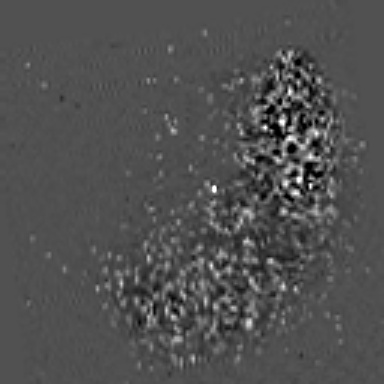

In [28]:
# # comvert images to camian movie
# TEMP = cm.movie(images)
# z_stack_movie = 15
# TEMP[...,z_stack_movie].play(magnification=3, backend='embed_opencv', fr=100)

Now restart the cluster to clean up memory

In [24]:
# restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='multiprocessing', n_processes=None, single_thread=False)

### Run CNMF

In [25]:
# INIT
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview)
cnm.params.set('spatial', {'se': np.ones((3,3,1), dtype=np.uint8)})

In [26]:
# %%capture
# FIT
cnm = cnm.fit(images)

Exception ignored in: <function PluginV3.__del__ at 0x7f583e1db060>
Traceback (most recent call last):
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/imageio/core/v3_plugin_api.py", line 370, in __del__
    self.close()
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/imageio/plugins/pillow.py", line 144, in close
    self._flush_writer()
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/imageio/plugins/pillow.py", line 485, in _flush_writer
    primary_image.save(self._request.get_file(), **self.save_args)
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/PIL/Image.py", line 2439, in save
    save_handler(self, fp, filename)
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/PIL/GifImagePlugin.py", line 704, in _save_all
    _save(im, fp, filename, save_all=True)
  File "/mnt/cup/

Exception ignored in: <function PluginV3.__del__ at 0x7f583e1db060>
Traceback (most recent call last):
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/imageio/core/v3_plugin_api.py", line 370, in __del__
    self.close()
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/imageio/plugins/pillow.py", line 144, in close
    self._flush_writer()
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/imageio/plugins/pillow.py", line 485, in _flush_writer
    primary_image.save(self._request.get_file(), **self.save_args)Exception ignored in: 
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/PIL/Image.py", line 2439, in save
<function PluginV3.__del__ at 0x7f583e1db060>    
save_handler(self, fp, filename)Traceback (most recent call last):
  File "/mnt/cup/labs/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/image

### View the results
View components per plane

In [13]:
# cnm.estimates.nb_view_components_3d(image_type='mean', dims=dims, axis=2);

### Component Evaluation

In [27]:
#%% COMPONENT EVALUATION
# the components are evaluated in two ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient

fr = 10 # approx final rate  (after eventual downsampling )
decay_time = 1.  # length of typical transient in seconds 
use_cnn = False  # CNN classifier is designed for 2d (real) data
min_SNR = 0.01      # accept components with that peak-SNR or higher
rval_thr = 0.8   # accept components with space correlation threshold or higher
cnm.params.change_params(params_dict={'min_SNR': min_SNR,
                                      'rval_thr': rval_thr,
                                      'use_cnn': use_cnn})

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(('Keeping ' + str(len(cnm.estimates.idx_components)) +
       ' and discarding  ' + str(len(cnm.estimates.idx_components_bad))))

Keeping 10 and discarding  0


### Re-run seeded CNMF
Now we re-run CNMF on the whole FOV seeded with the accepted components.

In [28]:
# %%time
cnm.params.set('temporal', {'p': p})
cnm2 = cnm.refit(images)
# STOP CLUSTER
cm.stop_server(dview=dview)

*** Variable cnn_preds has not the same number of components as A ***


In [29]:
with open(f'{results_dir}/{samples[samp_index]}_cnm2.pkl', 'wb') as f:
    pickle.dump(cnm2, f)

### View the results
Unlike the above layered view, here we view the components as max-projections (frontal in the XY direction, sagittal in YZ direction and transverse in XZ), and we also show the denoised trace.

In [30]:
# cnm2.estimates.nb_view_components_3d(image_type='mean', 
#                                      dims=dims, 
#                                      Yr=Yr, 
#                                      denoised_color='red', 
#                                      max_projection=True,
#                                      axis=2);